# Predicción Univariada y Multivariada de los Principales Índices Financieros del Mundo

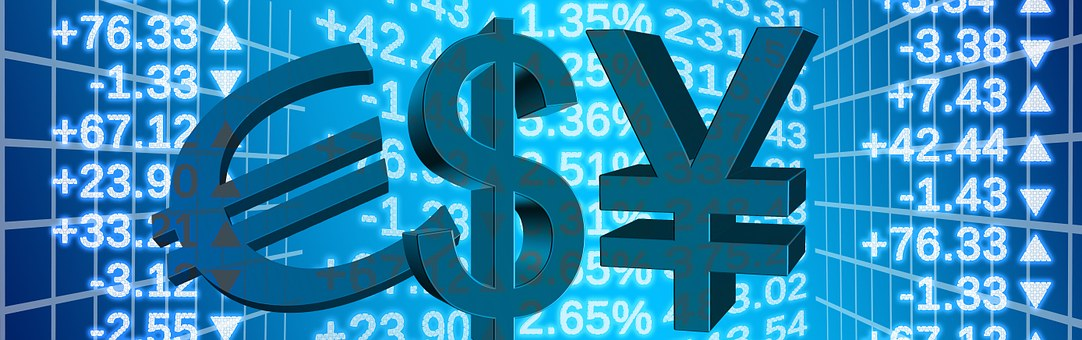

In [1]:
from IPython.display import Image
Image(filename='img/imagenStock.jpg' ,  width= 1280)

### Carga de bibliotecas

In [2]:
import pandas as pd
import numpy as np 
import seaborn as sb
from scipy.interpolate import interp1d
import sklearn

import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (15, 5)

### Carga del dataset

In [3]:
df = pd.read_csv("inputs/dataset.csv", index_col=0, parse_dates=True, dayfirst= True)
df.head()

,MERV,BVSP,GSPC,NDX,FTSE,GDAXI,FCHI,N225,HSI,SSEC,BSESN,DEXARUS,DEXBZUS,DEXUSUK,DEXUSEU,DEXJPUS,DEXHKUS,DEXCHUS,DOLAR_BLUE
FECHA,,,,,,,,,,,,,,,,,,,
1997-07-02,824.109985,13260.0,904.030029,975.929993,4751.399902,3867.530029,2909.500000,20196.41992,NaN,1199.06,4333.899902,0.9998,1.0767,1.6670,1.1223,114.52,7.7472,8.3210,NaN
1997-07-03,831.440002,13285.0,916.919983,986.520020,4831.700195,3939.729980,2937.000000,20121.41016,15055.70020,1150.62,4323.459961,0.9994,1.0778,1.6885,1.1242,113.46,7.7445,8.3214,NaN
1997-07-04,837.950012,13494.0,NaN,NaN,4812.799805,3946.729980,2934.500000,19968.00000,14823.00000,1159.34,4323.819824,0.9995,NaN,NaN,1.1230,NaN,NaN,NaN,NaN
1997-07-07,841.690002,13502.0,912.200012,991.039978,4810.700195,4003.350098,2947.699951,19705.16992,14858.59961,1096.82,4291.450195,0.9998,1.0779,1.6870,1.1226,112.60,7.7428,8.3218,NaN
1997-07-08,846.330017,13617.0,918.750000,1005.809998,4758.500000,4030.100098,2929.800049,19853.89063,14792.20020,1109.67,4306.390137,0.9999,1.0790,1.6885,1.1180,112.76,7.7436,8.3219,NaN


# Trabajo Práctico N°3: Introducción al Aprendizaje Automático

## Introducción

En los prácticos 1 y 2 se analizaron las series originales y se les realizaron diversas transformaciones. 
A partir de las series preprocesadas, en este práctico se persigue el objetivo general de entrenar algunos modelos predictivos univariantes sencillos y luego comparar su desempeño. 

En esta introducción se describen muy brevemente algunas metodologías propias de series temporales que serán necesarias para responder las consignas. La idea es solo introducirnos en lo mínimo necesario para adaptar lo visto en _Introducción al Aprendizaje Automático_ al caso de Series Temporales. Se proveen varios links al blog: [machinelearningmastery.com](https://machinelearningmastery.com/) de Jason Brownlee, porque contiene explicaciones muy claras y bastante código de Python que seguramente les será muy útil.

En la literatura estadística estándar, la selección de modelos (equivalente a la selección de features y de hiperparámetros) por lo general se realiza incorporando solo los componentes (features, algunos de los cuales pueden ser features retardados) que se prueban como estadísticamente significativos (esta es la forma de evitar el sobreajuste). Luego para validar los modelos se realizan dos tareas, una de ellas es evaluar la bondad de ajuste (si lo que predice el modelo es similar a lo que se observa) y la otra es chequear si se cumplen los supuestos del modelo.  Dichos supuestos por lo general se refieren a los términos de error, por lo que se realizan pruebas y se analizan gráficos de los residuos. 

### División en conjuntos de entrenamiento y test

Como se estudia en la materia _Introducción al Aprendizaje Automático_, para entrenar modelos y seleccionar cuál es el más adecuado, se debe __particionar los datos (ejemplos) en conjuntos de entrenamiento, validación y test__; o bien en conjuntos de entrenamiento y test, si se emplea validación cruzada. La práctica habitual para construir dichos subconjuntos, es por medio de selección aleatoria, a fines de garantizar que los mismos provengan de una misma distribución y a su vez evitar el sobreajuste. En el caso de datos de series temporales, dicha estrategia no resulta adecuada porque un muestreo aleatorio rompe el ordenamiento de los datos por lo que se pierde la autocorrelación que justamente es lo que le dá sentido al análisis. Por lo tanto, para dividir los conjuntos de entrenamiento y test se debe acudir a otras metodologías. 

Existen dos procedimientos de partición que son los más empleados para datos de series de tiempo. La forma más secilla consiste en particionar el dataset en un punto fijo del tiempo de modo tal que los datos mas antiguos se usan para entrenar los modelos y los mas nuevos para test([Train-Test Split](https://machinelearningmastery.com/backtest-machine-learning-models-time-series-forecasting/)). Otro procedimiento, denominado en el mismo blog como [Walk-Forward Validation](https://machinelearningmastery.com/backtest-machine-learning-models-time-series-forecasting/), consiste en realizar cortes recursivos, por ejemplo a partir de una ventana temporal inicial tomar los $s$ primeros datos para pronosticar el valor de la variable en $s+1$, luego tomar los $s+1$ primeros datos para estimar el valor en $s+2$, etc (debe notarse que el conjunto que se usa para entrenamiento crece en cada paso). Existe también una variación del segundo procedimiento en la que se mantiene fijo el tamaño del conjunto de entrenamiento, por ejemplo se usan los primeros $s$ datos para pronosticar el valor en $s+1$ como antes, pero en el siguiente paso se dropea la primera observación y se emplean los datos desde la observación 2 hasta la $s+1$ para pronosticar el valor en $s+2$ (entonces en cada paso el conjunto de entrenamiento esá formado por $s$ datos). 

### Entrenamiento de modelos

Exploraremos algunos modelos propios de la literatura estadística pero empleando una metodología de entrenamiento mas ligada a aprendizaje automático.
En la literatura estadística de Series Temporales se trabaja tanto con estimaciones puntuales (el pronóstico es un único número) como en la construcción de bandas de pronóstico (un rango entre los que se espera que esté el valor pronosticado con cierta probabilidad) y en la selección automática de los modelos se suelen emplear "criterios de información" tales como el de Akaike, Schwarz, Hannan-Quiin. En cambio en aprendizaje automático por lo general solo se busca efectuar una estimación puntual y para la selección de modelos (tuneo de hiperparámetros) se usan métricas predictivas. 

##### Modelos base

Una vez particionados los datos, por lo general es una buena idea estimar algunos modelos muy sencillos que sirven de referencia. Mas aún en el caso de los índices financieros, donde hay múltiples agentes intentando realizar los mejores pronósticos para, en base a ello, obtener cuantiosas ganancias vía trading. 

Para las tasas de retorno, el modelo base que surge naturalmente es un proceso formado por una constante mas un término aleatorio, $r_t = \alpha + \varepsilon_t$, por lo que los pronósticos consistirían en el valor promedio de la serie([Average Forecast](https://otexts.com/fpp2/simple-methods.html)). 

Dado que $r_t = y_{t-1}- y_{t}$ (representando $y$ a los logaritmos naturales de los índices), se tiene que $y_t = \alpha + y_{t-1} + \varepsilon_t$, o sea que un modelo base adecuado para trabajar con los logaritmos naturales de los índices es una caminata aleatoria (random walk) con drift ($\alpha$). En una caminata aleatoria sin drift, el valor de un momento está detertminado por el del período anterior mas una perturbación aleatoria, por lo tanto la regla para hacer pronosticos para el momento t+1 es simplemente usar el valor del momento t ([Naive Forecast](https://machinelearningmastery.com/persistence-time-series-forecasting-with-python/)). Si la misma también incluye un drift (como en este caso), el valor de un momento determinado está dado por el valor del momento anterior mas una perturbación aleatoria, mas una constante (el drift). Entonces el drift tiende a dotar a las series de componentes de tendencia similares a una tendencia determinística. Debe notarse que si bien conceptuamente existe el drift, por los análisis que hicimos en los prácticos anteriores el mismo es un número muy cercano a cero (el retorno diario promedio es muy pequeño en todos los índices).

##### Modelos ARIMA

Los modelos [Autorregresivos Integrados de Medias Móviles](https://otexts.com/fpp2/non-seasonal-arima.html) (ARIMA) emplean la autocorrelación de las series para mejorar los pronósticos.  Por lo general se representan como $ARIMA(p, d, q)$, donde $p$ indica la cantidad de retardos de la series que se incluyen, $d$ es la cantidad de veces que hay que diferenciar la serie para lograr su estacionariedad y $q$ es la cantidad de retardos del término de perturbación que se incluye, o sea, si $y'$ es la serie diferenciada $d$ veces, el modelo que se entrena es:

$$y_t^{'} = c + \phi_1 y_{t-1}^{'} +...+\phi_q y_{t-q}^{'}  + \theta_1 \varepsilon_{t-1}+...+ \theta_1\varepsilon_{t-q} + \varepsilon_{t}$$

Es útil tener en cuenta que los modelos "baseline" para los retornos y para los logaritmos naturales de los índices son de tipo ARIMA(0,0,0) y ARIMA(0,1,0); respectivamente.

##### Otros modelos

Modelos ARIMA estacionales, Suavizado Exponencial, X-13ARIMA-SEATS, Modelos Espacio-Estado (Filtro de Kalman).

### Métricas

En scikit learn están implementadas algunas métricas útiles para problemas de regresión habitualmente usadas en series temporales, tales como como el [Error Cuadrático Medio](https://scikit-learn.org/stable/modules/model_evaluation.html#mean-squared-error), el [Error Absoluto Medio](https://scikit-learn.org/stable/modules/model_evaluation.html#mean-absolute-error) y el [Error Absoluto Mediano](https://scikit-learn.org/stable/modules/model_evaluation.html#median-absolute-error).
Por supuesto que existen otras métricas. En particular, en la seccion 6 del artículo de [Tae-Hwy (2007)](https://pdfs.semanticscholar.org/dcd3/4f5077aa96df43c814e436b12d2a33401e9a.pdf) se proponen las métricas MFTR y MCFD para la evaluación de pronósticos sobre retornos financieros.


## Consignas


A partir de las series transformadas (logaritmos naturales de los índices y tasas de retorno), se proponen actividades orientadoras, sin perjuicio de que se puedan incorporar análisis adicionales. Las actividades no están separadas en secciones para resaltar que no se trata de pasos aislados, por ejemplo la separación train-test se va haciendo en foma simultánea al entrenamiento de los modelos.

**Se pide:**

* Realizar la división entre datos de entrenamiento y test usando el procedimiento [Walk-Forward Validation](https://machinelearningmastery.com/backtest-machine-learning-models-time-series-forecasting/). Alternativamente se la puede implementar usando [timeSeriesSplit](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html).
* Entrenar al menos un modelo "baseline" ([Average Forecast](https://otexts.com/fpp2/simple-methods.html) y
[Naive Forecast](https://machinelearningmastery.com/persistence-time-series-forecasting-with-python/)) para los retornos y para los logaritmos de los índices.
* Entrenar los correspondientes modelos ARIMA.
* Identificar cuáles son los parámetros y los hiperparamétros de los modelos ARIMA. 
* Tunear los hiperparamétros usando varias métricas ([Error Cuadrático Medio](https://scikit-learn.org/stable/modules/model_evaluation.html#mean-squared-error), [Error Absoluto Medio](https://scikit-learn.org/stable/modules/model_evaluation.html#mean-absolute-error), [Error Absoluto Mediano](https://scikit-learn.org/stable/modules/model_evaluation.html#median-absolute-error)). Puede ser útil la siguiente [ayuda](https://machinelearningmastery.com/grid-search-arima-hyperparameters-with-python/).
* Evaluar el desempeño de los modelos. ¿Cómo podemos saber en un problema de regresión si un modelo es "bueno"?¿Se pudo superar a los modelos "baseline"?

**Opcional:**

* Recortar el dataset para que no incluya el período asociado a la pandemia COVID19.
* Construir bandas de confianza para los pronósticos (http://alkaline-ml.com/pmdarima/usecases/stocks.html).
* Entrenar algún modelos de los mencionado en la sección "Otros modelos".
* Implementar las métricas MFTR y MCFD sugeridas para la evaluación de pronósticos sobre retornos financieros en la sección 6 del artículo de [Tae-Hwy (2007)](https://pdfs.semanticscholar.org/dcd3/4f5077aa96df43c814e436b12d2a33401e9a.pdf).

## Fecha de entrega

- __Versión preliminar: 10/8__ 

- __Version final: 16/8__

## Condiciones de entrega

Realizar un informe en el cual se presenten los resultados y conclusiones del análisis realizado. El mismo debe estar pensado para un público técnico pero que desconoce los aspectos propios del problema a resolver tal como los compañeros de clase. Dicho informe puede ser un notebook, a condición de que en el mismo se efectúe un análisis escrito suficientemente detallado de los resultados. 


## Desarrollo

#### Preparamos el ambiente para obtener la serie de retornos y logaritmos de los índices.
Haremos un tratamiento de los datos similar al del práctico anterior. 

In [4]:
df = df[df.index.dayofweek < 5]

df_interpolate = df.copy()

for col in df.columns:
    
    df_temp = df[[col]]
    df_temp['new_index'] = np.array(range(len(df_temp)))
    
    df_temp_dropna=df_temp.dropna()

    y = np.array(df_temp[col])
    x = np.array(df_temp.new_index)

    y_dropna = np.array(df_temp_dropna[col])
    x_dropna = np.array(df_temp_dropna.new_index)
    
    f_lineal = interp1d(x_dropna, y_dropna, fill_value="extrapolate")
    f_cubic = interp1d(x_dropna, y_dropna, kind='cubic', fill_value="extrapolate")

    y_lineal = f_lineal(x)
    y_cubic = f_cubic(x)
    
    df_interpolate[col] = y_cubic
    del df_temp, df_temp_dropna, x, y, x_dropna, y_dropna, f_lineal, f_cubic, y_lineal, y_cubic

In [5]:
df = df_interpolate.copy()

In [6]:
cepo_1 = (df.index >= '2011-10-28') & (df.index <= '2015-12-16')
cepo_2 = (df.index >= '2019-09-01') & (df.index <= '2020-05-08')
cepo = (cepo_1 | cepo_2)
df['DEXARUS'][cepo] = df['DOLAR_BLUE']

df_us = pd.DataFrame(index=df.index)
df_us['MERV'] = df['MERV'] / df['DEXARUS'] # Divido porque el par esta en X/US
df_us['BVSP'] = df['BVSP'] / df['DEXBZUS']
df_us['FTSE'] = df['FTSE'] * df['DEXUSUK'] # Multiplico porque el par esta en US/X
df_us['GDAXI'] = df['GDAXI'] * df['DEXUSEU']
df_us['FCHI'] = df['FCHI'] * df['DEXUSEU']
df_us['N225'] = df['N225'] / df['DEXJPUS']
df_us['HSI'] = df['HSI'] / df['DEXHKUS']
df_us['SSEC'] = df['SSEC'] / df['DEXCHUS']
# df_us['BSESNUS'] = df['BSESN'] / df['DEX?'] Falta el DEX de rupias indias? 

#A continuación agregamos los índices GSPC y NDX.
df_us['GSPC'] = df['GSPC']
df_us['NDX'] = df['NDX']

#### Definimos los dataframes df_ret y df_ln

In [7]:
df_ret = df_us.pct_change().replace(np.nan,0)
df_ln = np.log(df_us)

In [8]:
df_ret.head()

,MERV,BVSP,FTSE,GDAXI,FCHI,N225,HSI,SSEC,GSPC,NDX
FECHA,,,,,,,,,,
1997-07-02,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1997-07-03,0.009298,0.000863,0.030016,0.020393,0.011161,0.005594,-0.060765,-0.040444,0.014258,0.010851
1997-07-04,0.007729,0.015781,-0.003102,0.000707,-0.001918,-0.001982,-0.015259,0.007547,-0.003921,0.000044
1997-07-07,0.004162,0.000452,-0.002136,0.013985,0.004140,-0.011247,0.002421,-0.053943,-0.001231,0.004538
1997-07-08,0.005412,0.007489,-0.009971,0.002557,-0.010145,0.006118,-0.004572,0.011704,0.007180,0.014904


In [9]:
df_ln.head()

,MERV,BVSP,FTSE,GDAXI,FCHI,N225,HSI,SSEC,GSPC,NDX
FECHA,,,,,,,,,,
1997-07-02,6.714504,9.418606,8.977220,8.375751,8.091117,5.172511,7.635219,4.970511,6.806863,6.883391
1997-07-03,6.723759,9.419469,9.006794,8.395939,8.102216,5.178089,7.572529,4.929226,6.821020,6.894184
1997-07-04,6.731459,9.435127,9.003688,8.396646,8.100296,5.176106,7.557152,4.936744,6.817091,6.894227
1997-07-07,6.735612,9.435578,9.001550,8.410534,8.104428,5.164795,7.559571,4.881292,6.815859,6.898755
1997-07-08,6.741009,9.443040,8.991528,8.413088,8.094231,5.170894,7.554989,4.892927,6.823014,6.913548


## Comenzamos con TP3

In [10]:
#Aqui definimos los modelos predictivos "baseline"

def model_naive(data_X_train, data_X_test):
    
    get_prediction = data_X_train.iloc[-1]
    vector_prediction = pd.Series(index = data_X_test.index)
    vector_prediction[:]= get_prediction
 
    return vector_prediction

def model_average(data_X_train,data_X_test):
    
    get_prediction = data_X_train.mean()
    vector_prediction = pd.Series(index = data_X_test.index)
    vector_prediction[:]= get_prediction
 
    return vector_prediction

#### Realizar la división entre datos de entrenamiento y test usando el procedimiento Walk-Forward Validation. Alternativamente se la puede implementar usando timeSeriesSplit.

In [11]:
# Realizamos la división de los datos de train y test a partir de TimeSeriesSplit 
#(veamos que pasar para MERV)
from sklearn.model_selection import TimeSeriesSplit

tscv = TimeSeriesSplit(n_splits=5, max_train_size=None)

#### Entrenar al menos un modelo "baseline" para los retornos y para los logaritmos de los índices.

In [12]:
def get_prediction_tscv(df,col):
    X = df[col].iloc[-300:]

    for train_index, test_index in tscv.split(X):
        #print("Train:\n", train_index, "\nTest:\n", test_index)
        X_train, X_test = X[train_index], X[test_index]
        X_pred_naive = model_naive(X_train,X_test)
        X_pred_average = model_average(X_train,X_test)

        pd.concat([X_train,X_test], axis=0).plot(color = 'green' , ls='--', label = 'Serie')
        X_pred_average.plot(color = 'blue', ls='--', label = 'Average Pred.')
        X_pred_naive.plot(color = 'red', ls='--', label= 'Naive Ped.')
        plt.legend()
        plt.show()

        print()
    return X_test, X_pred_average, X_pred_naive

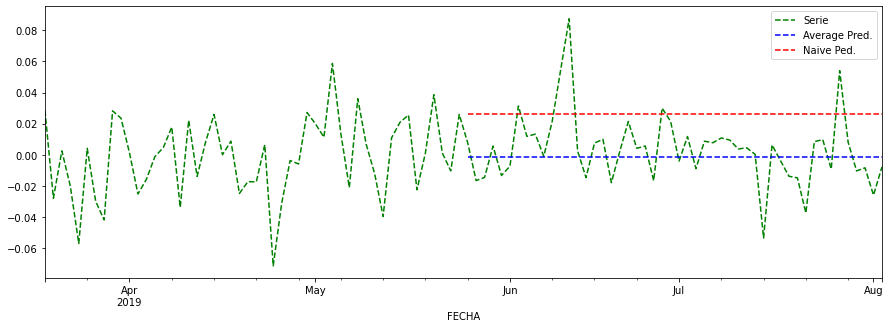

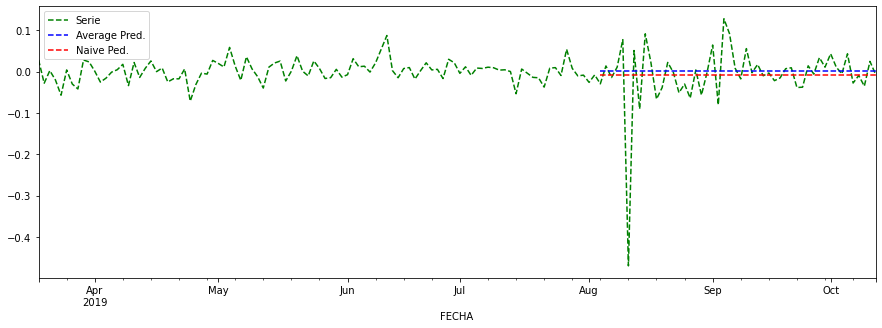

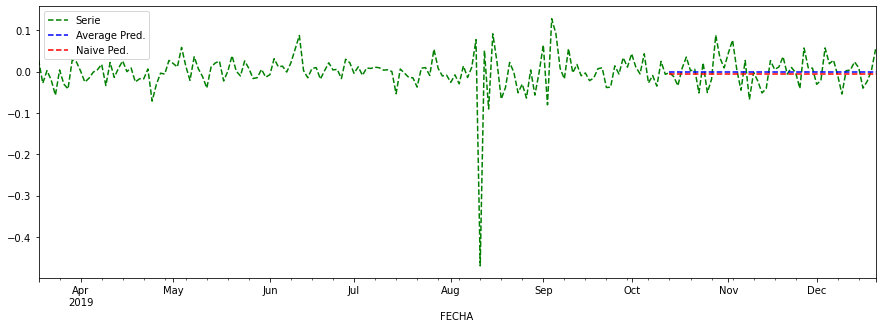

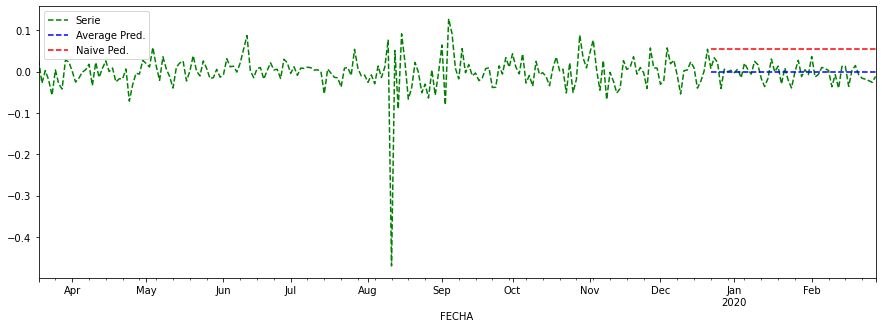

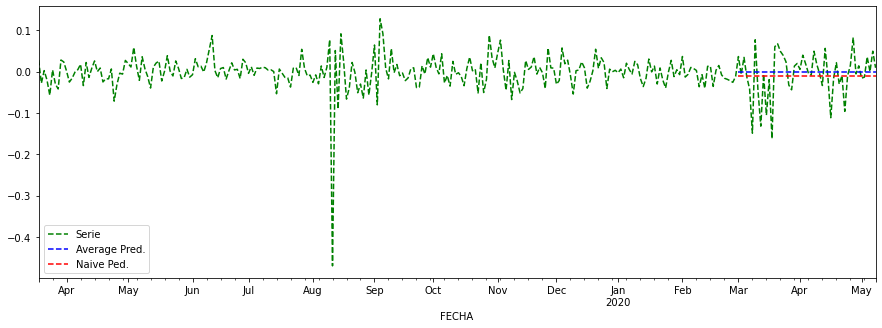

In [13]:
_,_,_ = get_prediction_tscv(df_ret,'MERV')

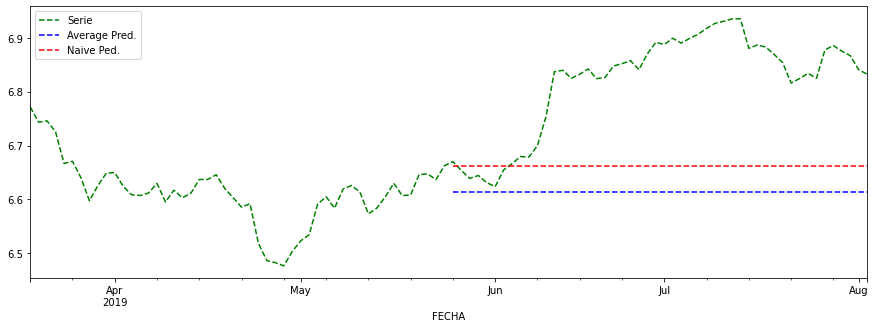

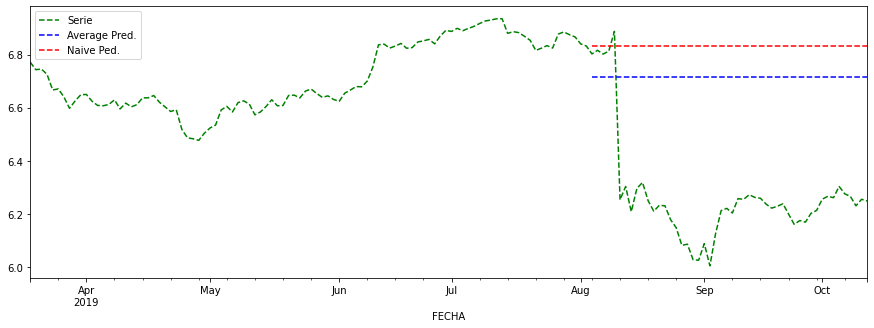

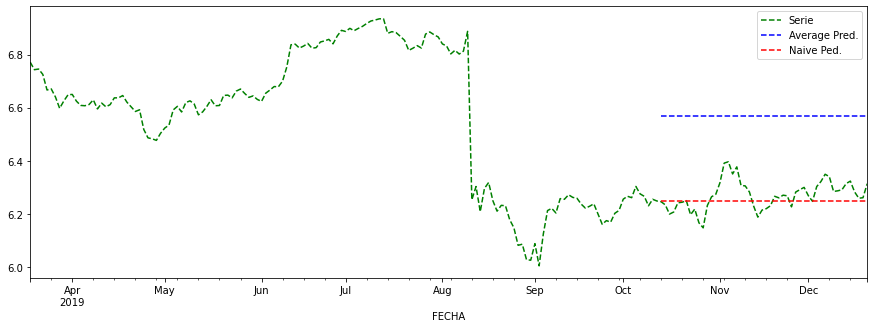

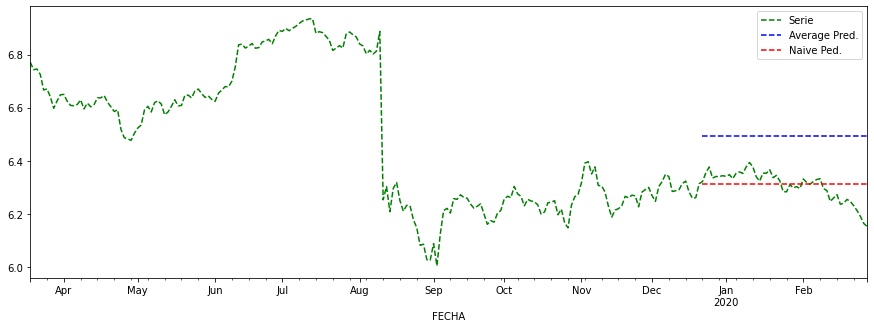

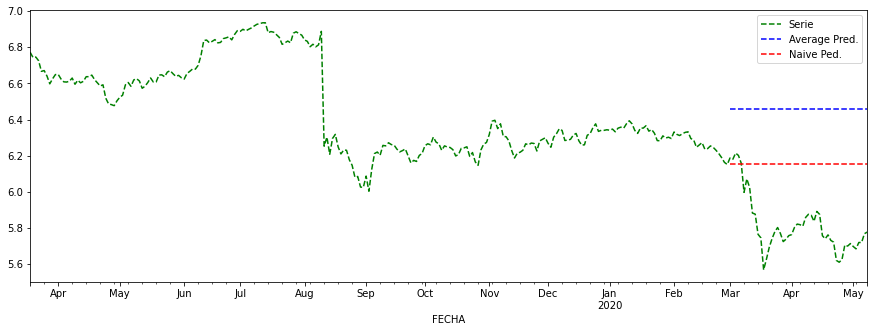

In [14]:
_,_,_ = get_prediction_tscv(df_ln,'MERV')

### WALK FORWARD VALIDATION

In [15]:
def model_naive(X_train, X_test):
    predictions = X_train.iloc[-1]
    vector_prediction = pd.Series(index=X_test.index)
    vector_prediction[:] = predictions
    return vector_prediction

def model_average(X_train, X_test):
    predictions = X_train.mean()
    vector_prediction = pd.Series(index=X_test.index)
    vector_prediction[:] = predictions
    return vector_prediction

In [16]:
class WalkForwardValidation:
    def __init__(self, df):
        self._results = {}
        self.df = df
        
    def predict(self, model, target, n_train=500):
        name = f'{target}_{model.__name__}'
        X = self.df[target]
        n_records = len(X)
        self._results[name] = pd.Series()
        for i in range(n_train, n_records):
            X_train, X_test = X.iloc[0:i], X.iloc[i:i+1]
            result = model(X_train, X_test)
            self._results[name] = pd.concat([self._results[name], result])
    
    @property
    def get_results(self, name=None):
        return self._results[name] if name else self._results

    def plot_results(self, configs, plot_col=None):
        for config in configs:
            name = config.pop('name')
            self._results[name].plot(**config)
        if plot_col:
            self.df[plot_col].plot(color='green' , ls='--', label = 'Serie')
        plt.legend()
        plt.show()
        

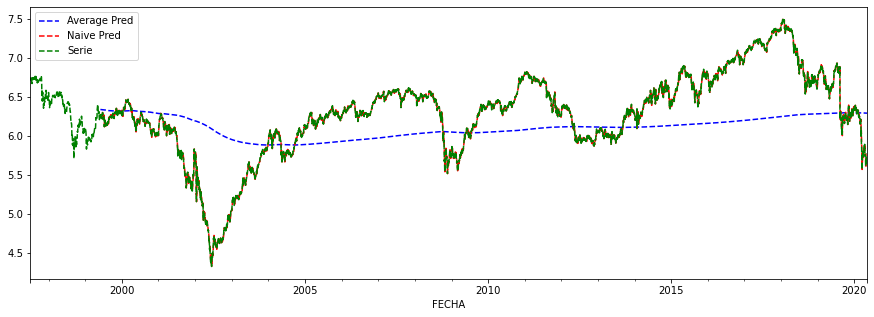

In [17]:
# Creamos el modelo para df_ln
wfcv = WalkForwardValidation(df_ln)

# Generamos las predicciones
wfcv.predict(model_average, 'MERV')
wfcv.predict(model_naive, 'MERV')


# Graficamos
plot_config = [
        {'name': 'MERV_model_average', 'label': 'Average Pred', 'ls': '--', 'color': 'blue'},
        {'name': 'MERV_model_naive', 'label': 'Naive Pred', 'ls': '--', 'color': 'red'}
]
wfcv.plot_results(plot_config, plot_col='MERV')

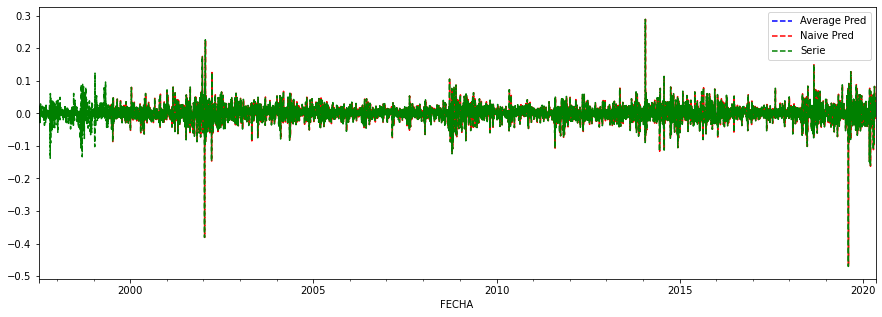

In [18]:
# Creamos el modelo para df_ret
wfcv = WalkForwardValidation(df_ret)

# Generamos las predicciones
wfcv.predict(model_average, 'MERV')
wfcv.predict(model_naive, 'MERV')


# Graficamos
plot_config = [
        {'name': 'MERV_model_average', 'label': 'Average Pred', 'ls': '--', 'color': 'blue'},
        {'name': 'MERV_model_naive', 'label': 'Naive Pred', 'ls': '--', 'color': 'red'}
]
wfcv.plot_results(plot_config, plot_col='MERV')

### ARIMA MODEL

Test MSE: 0.001


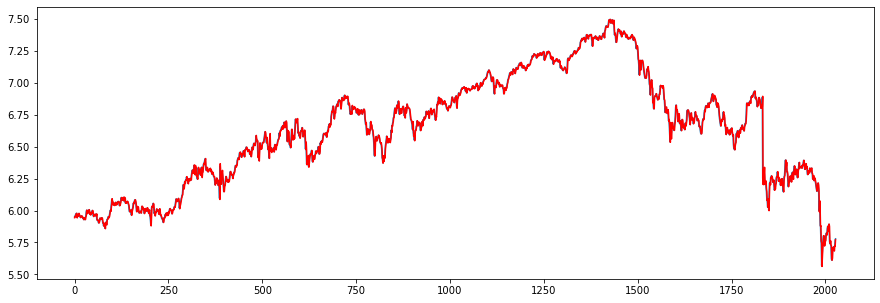

In [20]:
#In the present code, we'll try to fit an ARIMA model for the serie of log of MERVAL index
#This code takes about 20 minutes to execute!!!

from matplotlib import pyplot
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error

series = df_ln['MERV']
X = series.values
size = int(len(X) * 0.66)

# We split the dataset into 2, 66% of the data is for training, and 34% for test
#For each prediction we do, we add the true value to the history so in each time we're training the model with the newest values
train, test = X[0:size], X[size:len(X)] 
history = [x for x in train]
predictions = list()
for t in range(len(test)):
	model = ARIMA(history, order=(5,1,0))
	model_fit = model.fit(disp=0)
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = test[t]
	history.append(obs)
    #print('predicted=%f, expected=%f' % (yhat, obs))
    # If you wanna see the predicted and true values, just uncomment the code above
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)
# plot
pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.show()

# An error too slow indicates that the model is very good?